In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from math import floor
import leidenalg as la
import igraph as ig
import csv
from read_roi import read_roi_file, read_roi_zip
from glob import glob
import os
import pickle

In [2]:
class temporal_network:#object for creating node-aligned(every node exists every layer)
                       #with diagonal coupling(inter-layer edges exist only between node to itself)
        
    ##################################
    # TODO: extend omega(scalar) for vector and matrix
    ##################################
        
    def __init__(self, size, length, data, **kwargs):
        
        if length < 1: return('Object should be a multilayer network with at least 2 layers')
        if size < 3: return('Layers must have at least 3 nodes')
        
        self.size = size # number of nodes in every layer
        self.length = length # number of layers
        self.nodes = [i for i in range(self.size)]
        
        #### data: supra__adjacency, list_adjacency, edge_list
        
        ##         if supra__adjacency: creates the list adjacency matrix
        ##
        ##                     --- additional arguments ---
        ##                       - supra_adjacency: supra adjacency matrix of shape (size*time x size*time)
        
        
        ##
        ##         if edge__list: creates directed weighted multilayer network from the egde quadraplets
        ##                      given of the form (i,j,w,t). supra_adjacency and list_adjacency matrices 
        ##                      are automatically created. 
        ##
        ##                     --- additional arguments ---
        ##                       - edge_list: list of quadreplets e.g. [(0,2,w1,1),(2,1,w2,1),(0,1,w3,2),(0,2,w4,2)]
        ##                       - omega: interlayer coupling strength, can be a float only for now
        ##                       - kind: if ordinal, only adjacent layers gets connected with strength scalar 'omega'
        ##                               if cardinal, all layers get connected w/ each other w/ strength scalar 'omega'
        
        
        ##         if list__adjacency: creates the supra adjacency matrix from given list of adjacency matrices
        ##                             of monolayer networks
        ##                             TODO:add a warning to check if the adjacency matrices are node-aligned
        ##                      
        ##              
        ##                     --- additional arguments ---
        ##                       - list_adjacency: list of length 'length' that contains individual adjacency
        ##                                         matrices of each layer that are numpy arrays
        ##                       - omega: interlayer coupling strength, can be a float only for now
        ##                       - kind : if ordinal, only adjacent layers gets connected w/ strength scalar'omega'
        ##                                if cardinal, all layers get connected w/ each other w/ strength scalar'omega'
        ##                              
        ####
                    
        if  data == 'supra__adjacency':
            self.supra_adjacency = kwargs['supra_adjacency']
            list_adjacency = [ [] for i in range(length) ]
            
            for i in range(self.length):
                list_adjacency[i] = self.supra_adjacency[i*self.size:(i+1)*self.size,i*self.size:(i+1)*self.size]
            
            self.list_adjacency = list_adjacency
            
            edge_list = []
            for i in range(self.length):
                A = self.list_adjacency[i]
                firing = np.transpose(np.nonzero(A))
                for j,m in enumerate(firing):
                    quadreplet =(m[0],m[1],A[m[0],m[1]],i)
                    edge_list.append(quadreplet)
            self.edgelist = edge_list
                
        
        elif data == 'edge__list':
            self.edgelist = kwargs['edge_list']
            supra_adjacency = np.zeros((self.size*self.length,self.size*self.length))
            list_adjacency = [ [] for i in range(self.length) ]
            for q in range(self.length):
                list_adjacency[q]=np.zeros((self.size,self.size))
            
            for k,e in enumerate(self.edgelist):
                i,j,w,t = e[0], e[1], e[2],e[3]
                supra_adjacency[self.size*(t)+i][self.size*(t)+j] = w
                list_adjacency[t][i][j] = w

        
            ##filling off-diagonal blocks
            if kwargs['kind'] == 'ordinal':
                for n in range(self.size*(self.length-1)):
                    supra_adjacency[n][n+self.size] = kwargs['omega']
                    supra_adjacency[n+self.size][n] = kwargs['omega']
                
            elif kwargs['kind'] == 'cardinal':
                i = 0
                while self.length-i != 0:
                    i = i+1
                    for n in range(self.size*(self.length-i)):
                        supra_adjacency[n][n+i*self.size] = kwargs['omega']
                        supra_adjacency[n+i*self.size][n] = kwargs['omega']
            
            self.supra_adjacency = supra_adjacency
            self.list_adjacency = list_adjacency
            
        elif data == 'list__adjacency':
            self.list_adjacency = kwargs['list_adjacency']
            supra_adjacency = np.zeros((self.size*self.length,self.size*self.length))
            
            for i in range(self.length):
                supra_adjacency[i*self.size:(i+1)*self.size,i*self.size:(i+1)*self.size] = self.list_adjacency[i]
            
            ##filling off-diagonal blocks
            if kwargs['kind'] == 'ordinal':
                for n in range(self.size*(self.length-1)):
                    supra_adjacency[n][n+self.size] = kwargs['omega']
                    supra_adjacency[n+self.size][n] = kwargs['omega']
                
            elif kwargs['kind'] == 'cardinal':
                i = 0
                while self.length-i != 0:
                    i = i+1
                    for n in range(self.size*(self.length-i)):
                        supra_adjacency[n][n+i*self.size] = kwargs['omega']
                        supra_adjacency[n+i*self.size][n] = kwargs['omega']
            
            self.supra_adjacency = supra_adjacency
            
            edge_list = []
            for i in range(self.length):
                A = self.list_adjacency[i]
                firing = np.transpose(np.nonzero(A))
                for j,m in enumerate(firing):
                    quadreplet =(m[0],m[1],A[m[0],m[1]],i)
                    edge_list.append(quadreplet)
            self.edgelist = edge_list
            
    def aggragate(self, normalized = True):
        t = self.length
        n = self.size
        aggragated = np.zeros((n,n))
        
        for i,c in enumerate(self.list_adjacency):
            aggragated = aggragated + c
            
        if normalized: return (aggragated/t)
        else: return (aggragated)
            
    def modularity_matrix(self, omega, gamma):##TODO: fix modularity matrix
        N = self.size
        T = self.length
        B = np.zeros((N*T,N*T))
        two_mu = 0
        for i in range(T):
            k = np.sum(self.list_adjacency[i],0)
            two_m = np.sum(k,0)
            two_mu = two_mu + two_m
            B[i*N:(i+1)*N,i*N:(i+1)*N] = self.list_adjacency[i] - (gamma * k.T*k)/(two_m)
        two_mu = two_mu + 2*omega*N*(T-1)
        
        for p in range(N*(T-1)):
            B[p][p+N] = omega 
            B[p+N][p] = omega
            
        return(B)
    
    def edgelist2edges(self):
        T = self.length
        all_edges = [[] for i in range(T)]
        weights = []
        dtype = [('row',int),('column',int),('weight',float),('layer',int)]
        for k,e in enumerate(np.sort(np.array(self.edgelist, dtype=dtype),order='layer')):
            i,j,w,t = e[0], e[1], e[2],e[3]
            pair = (i,j)
            all_edges[t].append(pair)
            weights.append(w)
        return (all_edges, weights)
    
    def neighbors(self, node_id, layer):
        
        if node_id > self.size: return('Invalid node ID')
        if layer > self.length: return('Invalid layer')
        neighbors = []
        
        for k,e in enumerate(self.edgelist):
            i,j,w,t = e[0],e[1],e[2],e[3]
            if t != layer:pass
            else:
                if i != node_id:pass
                else:neighbors.append(j)
                    
        return(neighbors)
    
    def trajectories(self, thresh = 0.9, node_id = None):#function graphing the edge trajcetories of the temporal
        ## network. Tresh is for thresholding the paths that are strongere than the given value.
        ## if node_id is None, function is going to graph everything all of the nodes's trajectories.
        
        layers = []
        
        if node_id == None:
            for k in self.nodes:
                color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(self.size)]
                for j in range(1,self.length):
                    for i in self.neighbors(k, j):
                        if self.list_adjacency[j][k][i] > thresh:
                            layers.append((j-1, j))
                            layers.append((k, i))
                            layers.append('%s' %color[i])
            fig,ax = plt.subplots(1,1,figsize = (20,7))
            plt.plot(*layers,figure = fig)
            plt.title('node trajectories of all the cells that are stronger than %f'%(thresh),fontsize = 20)
            plt.xlabel('Layers',fontsize = 15)
            plt.ylabel('Nodes',fontsize = 15)
            
        else:
            color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(self.size)]
            for j in range(1,self.length):
                for i in self.neighbors(node_id,j):
                    if self.list_adjacency[j][node_id][i] > thresh:
                        layers.append((j-1, j))
                        layers.append((node_id, i))
                        layers.append('%s' %color[i])
                            
            fig,ax = plt.subplots(1,1,figsize = (20,7))
            plt.plot(*layers,figure = fig)
            plt.title('node trajectories of the cell %d that are stronger than %f'%(node_id,thresh),fontsize = 20)
            plt.xlabel('Layers',fontsize = 15)
            plt.ylabel('Nodes',fontsize = 15)

In [3]:
def normalized_cross_corr(x,y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    x_cov_std = np.nanmax(np.sqrt(np.correlate(x - x_mean, x - x_mean, 'full')))
    y_cov_std = np.nanmax(np.sqrt(np.correlate(y - y_mean, y - y_mean, 'full')))

    normalization = x_cov_std * y_cov_std
        

    unnormalized_correlation = np.correlate(x - x_mean, y - y_mean, 'full')
    
    corr_array = unnormalized_correlation/normalization

    return(corr_array)

def max_norm_cross_corr(x1, x2):
    
    correlation= normalized_cross_corr(x1, x2)
    
    lag = abs(correlation).argmax() - len(x1)+1
    
    max_corr = max(abs(correlation))
    
    return(max_corr, lag)

def cross_correlation_matrix(data):
    #input: n x t matrix where n is the number of rois and t is the duration of the time series
    #return: n x n symmetric cross correlation matrix, nxn uppertriangular cross correlation matrix and lag matrix
    n, t = data.shape
    X = np.zeros((n,n))
    lag = np.zeros((n,n))
    
    for i in range(n-1):
        for j in range(i+1,n):
            X[i][j],lag[i][j] = max_norm_cross_corr(data[i,:],data[j,:])
    X[np.isnan(X)] = 0
    lag[np.isnan(lag)] = 0
    
    X_full = X + X.T
    lag = lag + lag.T
    return(X_full, X, lag)

In [4]:
def read_csv(path, output, subject, roi, subject_roi):
    trace=open( path + output + subject + "_trace.csv", "r")
    spike=open( path + output + subject + "_spikes_complexity.csv", "r")
    reader_trace = csv.reader(trace)
    reader_spike = csv.reader(spike)
    n = read_roi(path, roi, subject_roi)
    traces = np.zeros((n,8000)) # roi x time
    spikes = np.zeros((n,8000)) # roi x time
    #row_count = sum(1 for row in reader)
    
    for i,line in enumerate(reader_trace):
        for j in range(len(line)):
            traces[i][j]=line[j]
    for i,line in enumerate(reader_spike):
        for j in range(len(line)):
            spikes[i][j]=line[j]
    return(traces, spikes)
            
def read_roi(path, roi, subject_roi):
    roi = read_roi_zip(glob(path+roi+subject_roi +'.zip')[0])
    n = len(roi)
    for i, R in enumerate(roi):
        x = roi[R]['x']
        y = roi[R]['y']
    return(n)

def load_obj(name):
    with open('/Users/bengieru/MLN/subjects/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

def read_pv(m_type, mice):# this only read pv cells so far, TODO extend this to sst and non-track mice
    
    ##m_type: either 'het' or 'wt'
    ##mice: subject
    
    het_or_wt = 'pv_' + m_type
    pvs = load_obj(het_or_wt)
    subject = mice.split('_')[0] + '_' + mice.split('_')[1] + '_' + mice.split('_')[2] + '_' + mice.split('_')[3]
    
    if mice.split('_')[-1] == 'baseline':index = 0
    elif mice.split('_')[-1] == 'early':index = 1
    elif mice.split('_')[-1] == 'pre':index = 2
        
    pv_indices=[i-1 for i in pvs[subject][index]]#adjust python indexing starting from 0
    
    return(pv_indices)

def bin_time_series(array, binsize, gaussian=True, **kwargs):
    binned_spikes = []
    for i in range(len(array)):
        A = array[i].reshape(binsize,int(8000/binsize))
        if gaussian:
            A = gaussian_filter(A,kwargs['sigma'])
        binned_spikes.append(A)
    return(np.array(binned_spikes))

def gaussian_filter(array,sigma):
    #sigma=0.25==gaussian kernel with length 3
    #sigma=0.5==gaussian kernel with length 5
    #sigma=1==gaussian kernel with length 9
    return(gaussian_filter1d(array,sigma))

In [5]:
path = '/Users/bengieru/MLN/data/' ## base path
output = 'Johan_Clean_Traces_Features_and_Spikes/' #spikes and traces file
roi = 'sarah_ROI' #roi file
subject_roi = '/mouse_1_session_1_baseline' #subject
subject = 'm_1_session_1_baseline'# subject

In [6]:
time = 500 ## binning the time into chunks of
n = read_roi(path, roi, subject_roi) ## number of rois
t = int(8000/time) ## number of layers
traces, spikes = read_csv(path, output, subject, roi, subject_roi) #read the networks
binned_spikes = bin_time_series(spikes, time, gaussian = True, sigma=0.25) # bin the spikes into fixed length and apply gaussian kernel of length 3

In [7]:
##create cross-correlation matrices that are the adjacency matrices of the network at each layer
##create the same but uppertriangular cross correlation matrices for igraph
adjacency_matrices = []
upper_adjacency_matrices = []
for i in range(binned_spikes.shape[2]):
    adjacency_matrices.append(cross_correlation_matrix(binned_spikes[:,:,i])[0])
    upper_adjacency_matrices.append(cross_correlation_matrix(binned_spikes[:,:,i])[1])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [8]:
##TN- directed full temporal
##TNU- undirected full temporal
TN = temporal_network(n, t, data = 'list__adjacency', list_adjacency = adjacency_matrices, omega = 1, kind= 'ordinal')
TNU = temporal_network(n, t, data = 'list__adjacency', list_adjacency = upper_adjacency_matrices, omega = 1, kind= 'ordinal')
pv = read_pv('het',subject)

In [9]:
A = np.array([[0,1,0,1],[1,0,0,1],[0,0,0,1],[1,1,1,0]])
B = np.array([[0,0,1,0],[0,0,1,1],[1,1,0,0],[0,1,0,0]])
adjacency = [A,B]
TN_test = temporal_network(4, 2, data = 'list__adjacency', list_adjacency = adjacency, omega = 1, kind = 'ordinal')
#TN_test.edgelist

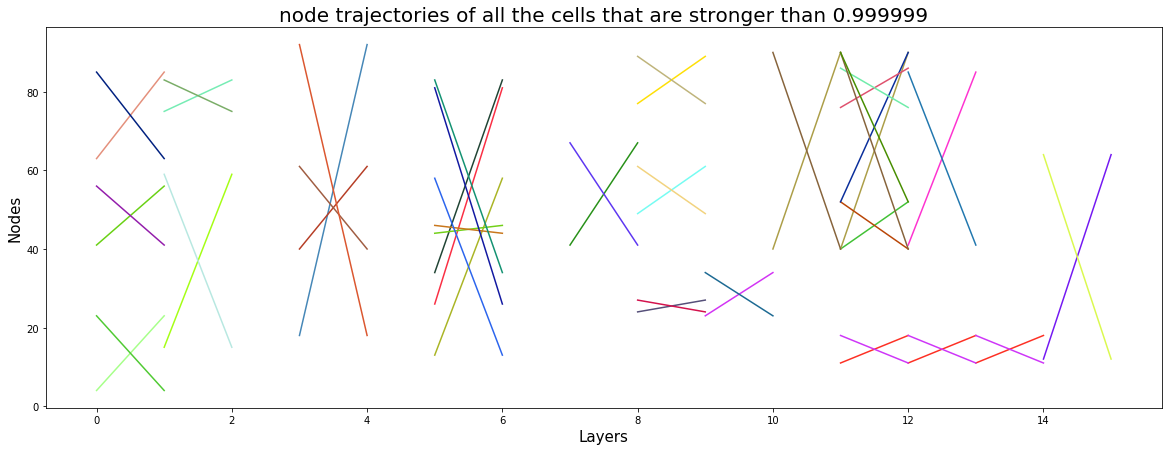

In [15]:
TN.trajectories(thresh = 0.999999, node_id = None)